In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nx = 31
x = np.linspace(0,3,nx)

In [3]:
dx = x[2] - x[1]
gamma = 1.4
gamma_inverse = 1/gamma;
nt = 1400
cfl = 0.5
total_time = 0;

In [4]:
#initial profile
rho = 1 - (0.3146*x)
T =   1 - (0.2314*x)
v = (0.1 + 1.09*x)*(T**0.5)
A = 1 + 2.2*((x-1.5)**2)
print(v)
print(T)
print(rho)

dv_dt_p = np.zeros((nx))
drho_dt_p = np.zeros((nx))
dT_dt_p = np.zeros((nx))

dv_dt_c = np.zeros((nx))
drho_dt_c = np.zeros((nx))
dT_dt_c = np.zeros((nx))

[0.1        0.20656772 0.31055431 0.41191227 0.5105917  0.60654011
 0.69970225 0.79001982 0.87743124 0.96187135 1.04327104 1.12155693
 1.19665091 1.26846965 1.33692406 1.40191865 1.46335081 1.52110994
 1.57507649 1.62512075 1.67110158 1.71286469 1.75024077 1.78304316
 1.81106497 1.83407564 1.85181659 1.86399585 1.87028111 1.87029082
 1.86358258]
[1.      0.97686 0.95372 0.93058 0.90744 0.8843  0.86116 0.83802 0.81488
 0.79174 0.7686  0.74546 0.72232 0.69918 0.67604 0.6529  0.62976 0.60662
 0.58348 0.56034 0.5372  0.51406 0.49092 0.46778 0.44464 0.4215  0.39836
 0.37522 0.35208 0.32894 0.3058 ]
[1.      0.96854 0.93708 0.90562 0.87416 0.8427  0.81124 0.77978 0.74832
 0.71686 0.6854  0.65394 0.62248 0.59102 0.55956 0.5281  0.49664 0.46518
 0.43372 0.40226 0.3708  0.33934 0.30788 0.27642 0.24496 0.2135  0.18204
 0.15058 0.11912 0.08766 0.0562 ]


In [5]:
mass_flow_rate_initial = rho*v*A
throat = np.where(A==1)
throat = throat[0]
rho[throat]

mass_flow = np.array((nx))
pressure = np.array((nx))
mach_number = np.array((nx))

In [6]:
rho_old = np.array((nx))
v_old = np.array((nx))
T_old = np.array((nx))

rho_old = rho[:]
v_old = v[:]
T_old = T[:]
T_old

rho_throat = np.zeros((nt))
pressure_throat = np.zeros((nt))
velocity_throat = np.zeros((nt))
temp_throat = np.zeros((nt))
mass_flow_throat = np.zeros((nt))
mach_number_throat = np.zeros((nt))

dv_dt_throat = np.zeros((nt))
drho_dt_throat = np.zeros((nt))

mass_flow_50 = np.zeros((nx))
mass_flow_100 = np.zeros((nx))
mass_flow_150 = np.zeros((nx))
mass_flow_200 = np.zeros((nx))
mass_flow_700 = np.zeros((nx))

# Solving the Non-conservative forms

In [7]:
for time in range(nt):

    rho_old = rho.copy()
    T_old = T.copy()
    v_old = v.copy()

    dt=np.min(0.5*dx/(T[1:]**0.5+v[1:]))
    
    #print(f"dt = {dt}")
    
    dv_dt_av = np.zeros((nx))
    drho_dt_av = np.zeros((nx))
    dT_dt_av = np.zeros((nx))

    #Running the predictor loop
    for i in range(1,nx-1):
        dv_dx = (v[i+1] - v[i])/dx                     #dv_dx[1:] = v[2:-1] - v[1:-2]
        dA_dx = (np.log(A[i+1]) - np.log(A[i]))/dx      
        drho_dx = (rho[i+1]-rho[i])/dx
        dT_dx = (T[i+1] - T[i])/dx

        t_rho = T[i]/rho[i]
    
        drho_dt_p[i] = -(rho[i]*dv_dx) -(rho[i]*v[i]*dA_dx) - (v[i]*drho_dx)
        dv_dt_p[i] = -(v[i]*dv_dx) - (gamma_inverse*(dT_dx + t_rho*drho_dx))
        dT_dt_p[i] = -(v[i]*dT_dx) - ((gamma - 1)*T[i]*(dv_dx + (v[i]*dA_dx)))
    
        #solution update    
        v[i] = v[i] + dv_dt_p[i]*dt
        rho[i] = rho[i] + drho_dt_p[i]*dt
        T[i] = T[i] + dT_dt_p[i]*dt 
    
    #Corrector step
    for i in range(nx-2,0,-1):
        dv_dx = (v[i] - v[i-1])/dx
        dA_dx = (np.log(A[i]) - np.log(A[i-1]))/dx      
        drho_dx = (rho[i]-rho[i-1])/dx
        dT_dx = (T[i] - T[i-1])/dx

        t_rho = T[i]/rho[i]
        
        drho_dt_c[i] = -(rho[i]*dv_dx) - (rho[i]*v[i]*dA_dx) - (v[i]*drho_dx)
        dv_dt_c[i] = -(v[i]*dv_dx) - (gamma_inverse*(dT_dx + t_rho*drho_dx))
        dT_dt_c[i] = -(v[i]*dT_dx) - (gamma - 1)*T[i]*(dv_dx + (v[i]*dA_dx))

    #solution update
        dv_dt_av[i] = 0.5*(dv_dt_p[i] + dv_dt_c[i])
        drho_dt_av[i] = 0.5*(drho_dt_p[i] + drho_dt_c[i])
        dT_dt_av = 0.5*(dT_dt_p[i] + dT_dt_c[i])
        
        v[i] = v_old[i] + 0.5*(dv_dt_p[i] + dv_dt_c[i])*dt
        T[i] = T_old[i] + 0.5*(dT_dt_p[i] + dT_dt_c[i])*dt
        rho[i] = rho_old[i] + 0.5*(drho_dt_p[i] + drho_dt_c[i])*dt
    
    #inlet
    rho[0] = 1
    T[0] = 1
    v[0] = 2*v[1] - v[2]

    #outlet
    rho[nx - 1] = 2*rho[nx-2] - rho[nx-3]
    v[nx-1] = 2*v[nx-2] - v[nx-3]
    T[nx - 1] = 2*T[nx-2] - T[nx-3]

    mass_flow = rho*A*v
    pressure = rho*T
    mach_number = v/T**0.5

    rho_throat[time] = rho[throat]
    velocity_throat[time] = v[throat]
    pressure_throat[time] = pressure[throat]
    temp_throat[time] = T[throat]
    mach_number_throat[time] = mach_number[throat]
    mass_flow_throat[time] = mass_flow[throat]

    dv_dt_throat[time] = 0.5*(dv_dt_p[throat] + dv_dt_c[throat])
    drho_dt_throat[time] = 0.5*(drho_dt_p[throat] + drho_dt_c[throat])

    total_time += dt
    if(time == 50):
        mass_flow_50[:] = mass_flow[:]
    if(time == 100):
        mass_flow_100[:] = mass_flow[:]
    if(time == 150):
        mass_flow_150[:] = mass_flow[:]
    if(time == 200):
        mass_flow_200[:] = mass_flow[:]
    if (time == 700):
        mass_flow_700[:] = mass_flow[:]


In [8]:
mass_flow_rate_initial

array([0.595     , 1.06276704, 1.37300516, 1.55481402, 1.63449283,
       1.63562033, 1.57913679, 1.48342831, 1.36441344, 1.23563255,
       1.10833985, 0.99159863, 0.89237973, 0.81566373, 0.76454719,
       0.74035324, 0.74274724, 0.76985784, 0.81840432, 0.88383089,
       0.96044892, 1.04158836, 1.11975966, 1.18682805, 1.23420224,
       1.25304047, 1.23447738, 1.16987631, 1.05111324, 0.87090077,
       0.62316338])

In [9]:
print(v)

[0.09878184 0.1120053  0.12522876 0.14260738 0.16226419 0.18655142
 0.21544232 0.25076619 0.29357149 0.34578022 0.40901975 0.48502902
 0.57476627 0.67800507 0.79252452 0.91400801 1.03665401 1.15461144
 1.26341026 1.3605908  1.44558439 1.51896848 1.58207817 1.63618819
 1.68295169 1.72311582 1.75856666 1.78869089 1.816723   1.83925517
 1.86178734]


In [10]:
print(rho)

[1.         0.99779703 0.99703034 0.99427741 0.99164719 0.98734222
 0.98181488 0.97378775 0.96262348 0.94666945 0.92413506 0.89250035
 0.84918067 0.79207381 0.72097542 0.63869089 0.55102888 0.46498576
 0.38635487 0.31838096 0.2618377  0.21592013 0.17907414 0.14965467
 0.12609971 0.10721078 0.09186352 0.07947623 0.06904757 0.06095248
 0.05285738]


In [11]:
print(T)

[1.         0.99911406 0.99881068 0.99770434 0.99665046 0.99491686
 0.99268821 0.98943596 0.98488961 0.97833884 0.96897984 0.95561765
 0.93686888 0.91127345 0.87781065 0.83646084 0.78860541 0.73680453
 0.68402407 0.63283438 0.58495055 0.54126673 0.50199276 0.4670212
 0.43592327 0.4083995  0.38380259 0.36210562 0.34228402 0.32527911
 0.30827419]


In [12]:
T[15]

0.8364608415446011

In [13]:
rho[15]

0.6386908867434187

In [14]:
T_old

array([1.        , 0.99911406, 0.99881068, 0.99770434, 0.99665046,
       0.99491686, 0.99268821, 0.98943596, 0.98488961, 0.97833884,
       0.96897984, 0.95561765, 0.93686888, 0.91127345, 0.87781065,
       0.83646084, 0.78860541, 0.73680453, 0.68402407, 0.63283438,
       0.58495055, 0.54126672, 0.50199276, 0.46702119, 0.43592327,
       0.4083995 , 0.38380259, 0.36210562, 0.34228402, 0.3252791 ,
       0.30827419])

Text(0, 0.5, 'Mass Flow Rate(initial)')

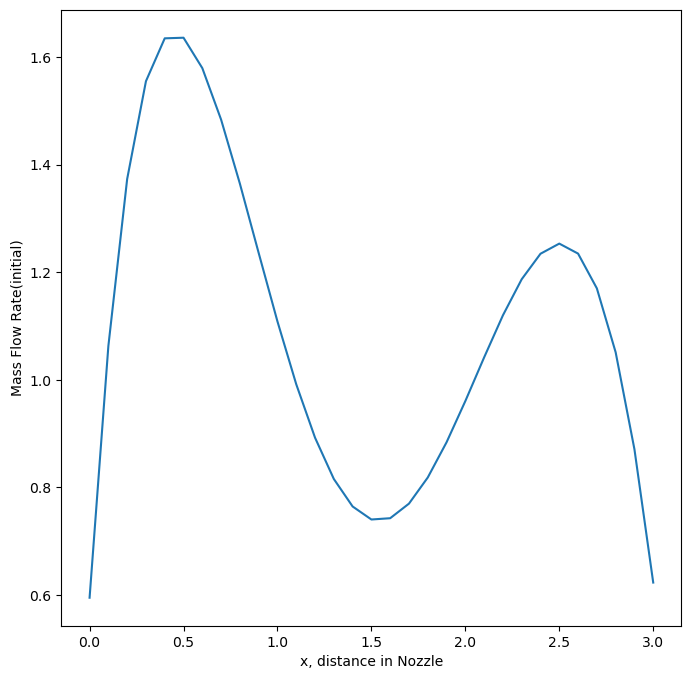

In [15]:
fig = plt.figure(figsize=(8,8),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(x[:],mass_flow_rate_initial[:],label = "initial mass flow rate")
ax.set_xlabel("x, distance in Nozzle")
ax.set_ylabel("Mass Flow Rate(initial)")

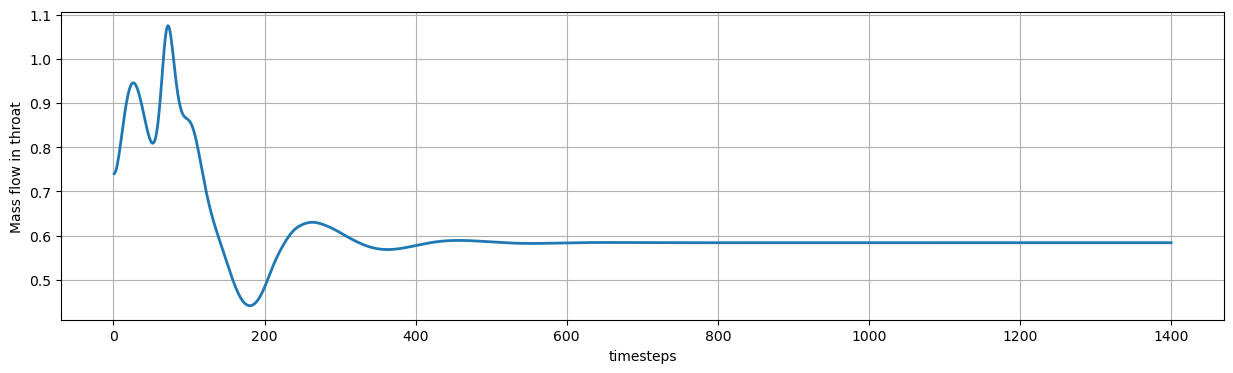

In [16]:
fig = plt.figure(figsize=(15,4),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,nt,nt),mass_flow_throat[:], label = "mass flow rate (throat)",linewidth = 2)
ax.set_xlabel("timesteps")
ax.set_ylabel("Mass flow in throat")
plt.rc('axes', labelsize = 20)
ax.grid()

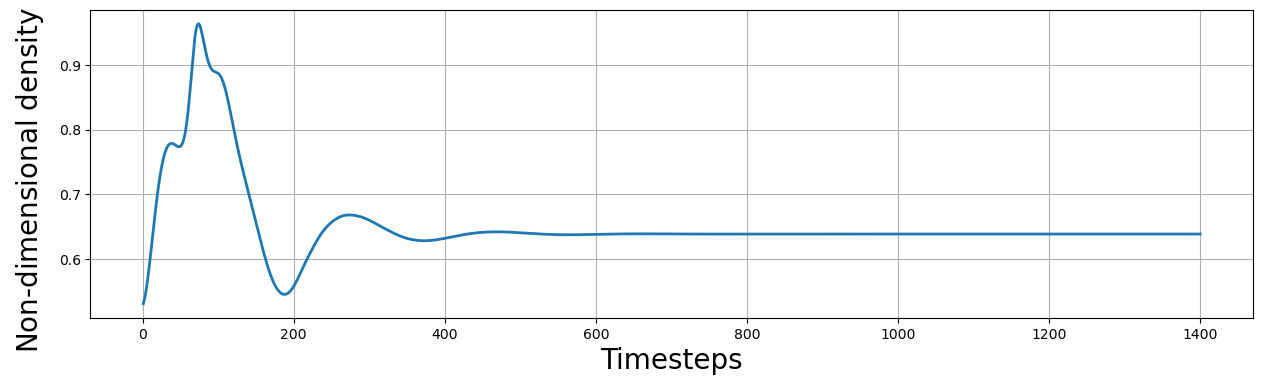

In [17]:
fig = plt.figure(figsize=(15,4),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,nt,nt),rho_throat[:],label="density in throat", linewidth = 2)
ax.set_xlabel("Timesteps")
ax.set_ylabel(r"Non-dimensional density $\frac{\rho}{\rho_0}$")
plt.rc('axes', labelsize = 17)
ax.grid()

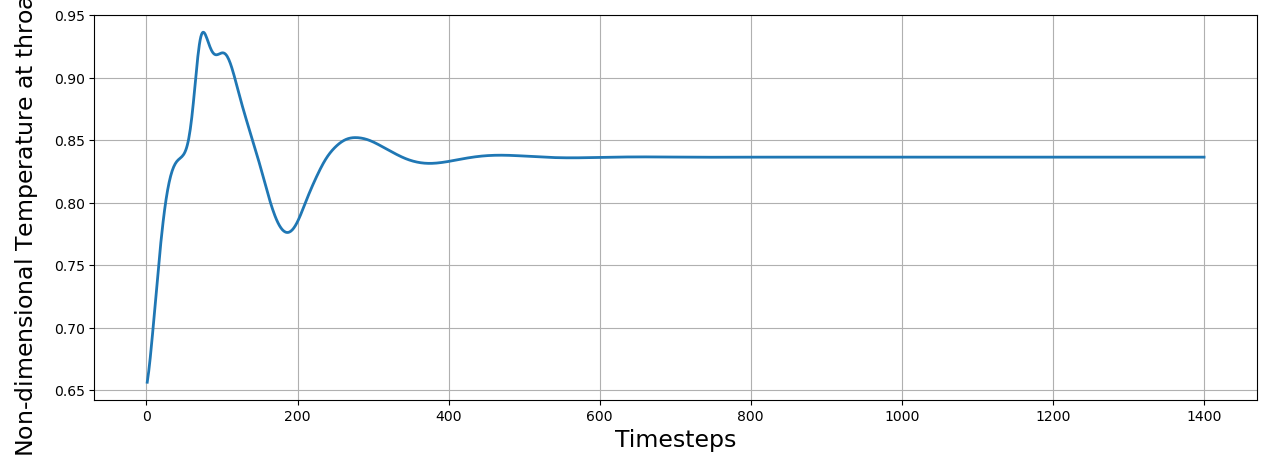

In [18]:
fig = plt.figure(figsize=(15,5),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,nt,nt),temp_throat[:],label = "temp. in throat", linewidth = 2)
ax.set_xlabel("Timesteps")
ax.set_ylabel(r"Non-dimensional Temperature at throat $\frac{T}{ T_0}$")
plt.rc('axes', labelsize = 13)
ax.grid()

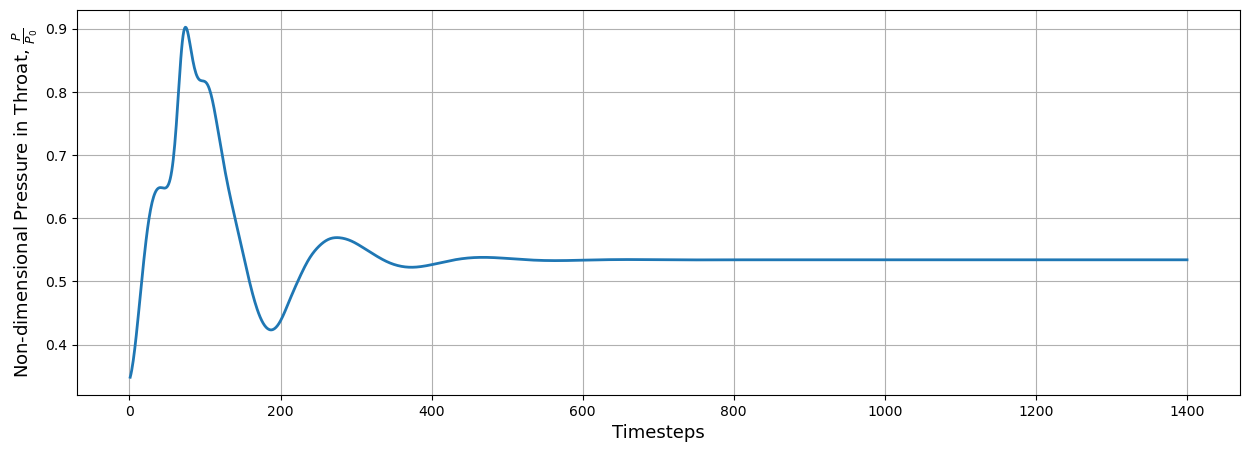

In [19]:
fig = plt.figure(figsize=(15,5),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,nt,nt),pressure_throat[:],label = "pressure in throat", linewidth = 2)
ax.set_xlabel("Timesteps")
ax.set_ylabel(r"Non-dimensional Pressure in Throat, $\frac{P}{P_0}$")
plt.rc('axes', labelsize = 13)
ax.grid()

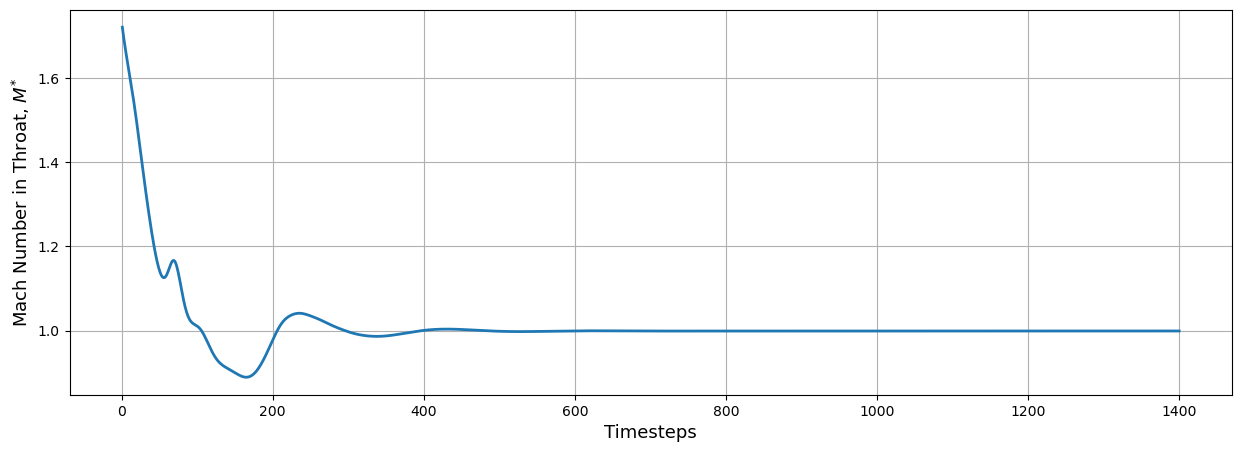

In [20]:
fig = plt.figure(figsize=(15,5),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,nt,nt),mach_number_throat[:],linewidth = 2)
ax.set_xlabel("Timesteps")
ax.set_ylabel(r"Mach Number in Throat, $M^{*}$")
plt.rc('axes', labelsize = 16)
ax.grid()

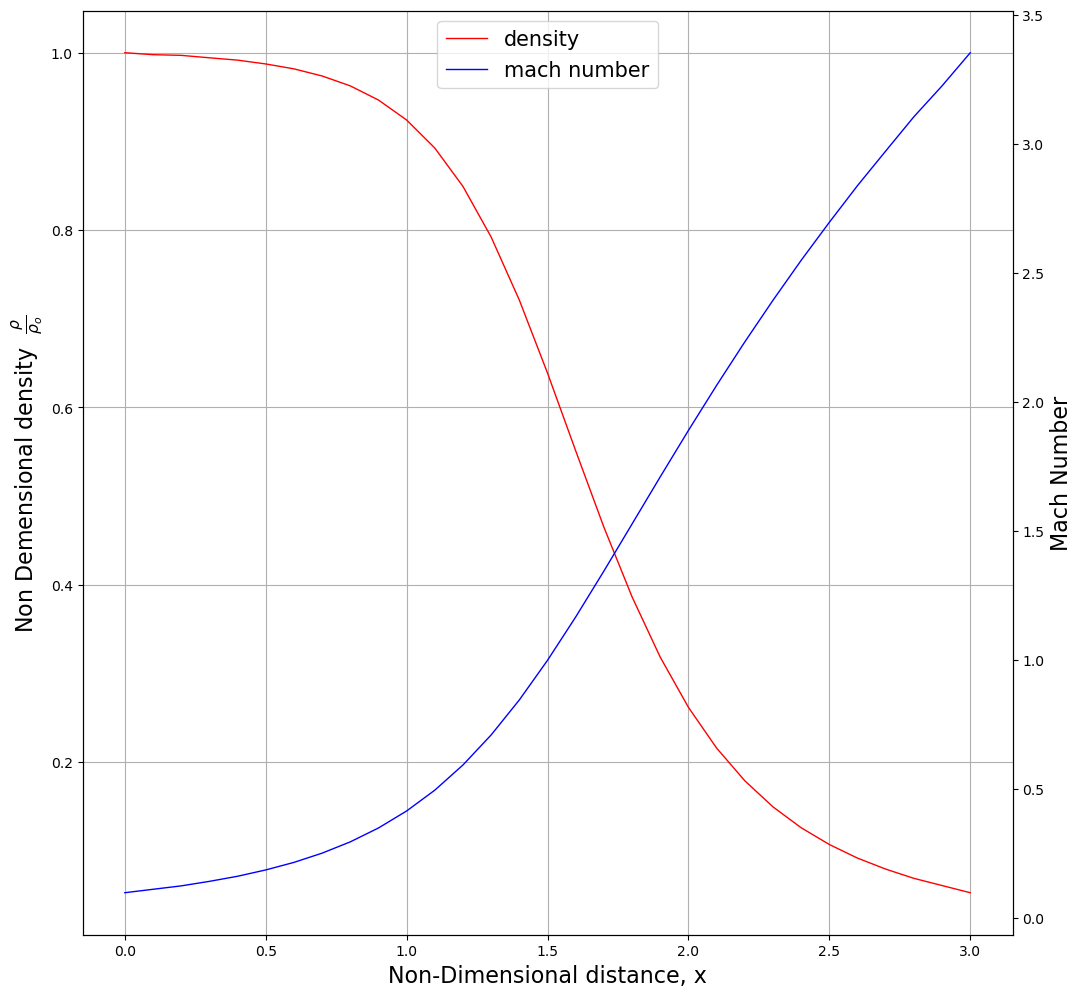

In [21]:
fig = plt.figure(figsize=(12,12), dpi = 100)
ax = fig.add_subplot(111)

ax.plot(x[:], rho[:], label = 'density', linewidth = 1, color = 'red')

ax2 = ax.twinx()
ax2.plot(x[:], mach_number[:], label = 'mach number',linewidth = 1,color = 'blue')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc=9,prop={'size': 15})


ax.set_xlabel("Non-Dimensional distance, x")
ax.set_ylabel(r"Non Demensional density  $\frac{\rho}{\rho_o}$")
ax2.set_ylabel("Mach Number")
ax.grid()
plt.show()

Text(0, 0.5, '$M$')

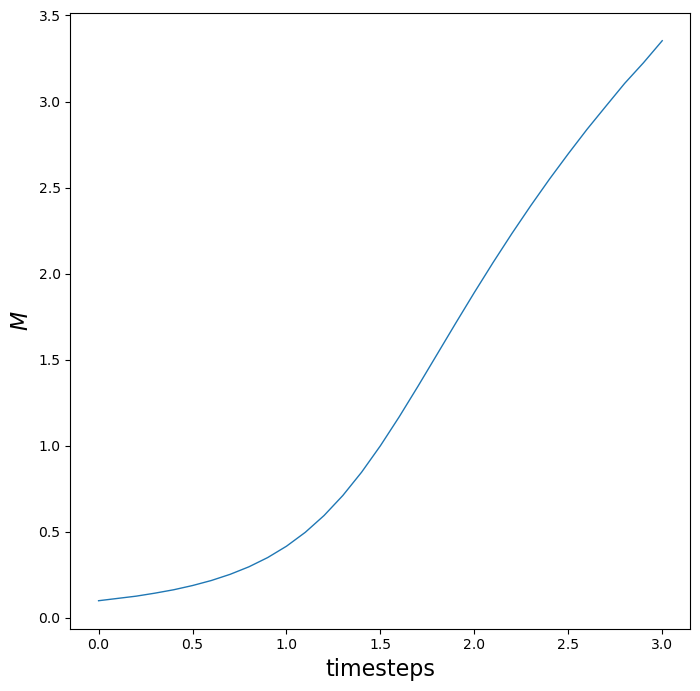

In [22]:
fig = plt.figure(figsize=(8,8),dpi = 100)
ax = fig.add_subplot(111)
ax.plot(x[:],mach_number[:],linewidth = 1)
ax.set_xlabel("timesteps")
ax.set_ylabel(r"$M$")

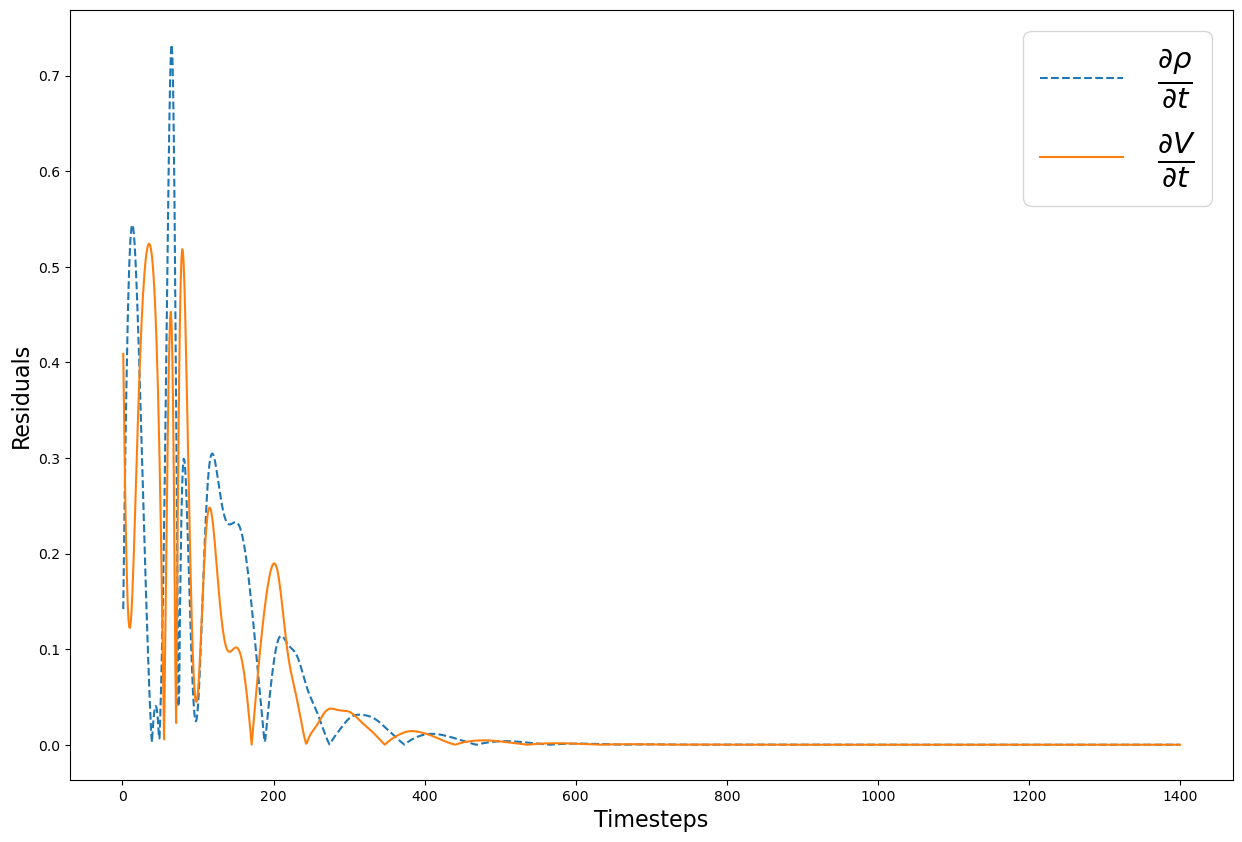

In [23]:
fig = plt.figure(figsize=(15,10), dpi = 100)
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,nt,nt), np.absolute(drho_dt_throat[:]), '--',label = r'$\frac{\partial \rho}{\partial t}$')
ax.plot(np.linspace(1,nt,nt), np.absolute(dv_dt_throat[:]), label = r'$\frac{\partial V}{\partial t}$')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Residuals')
plt.rc('axes', labelsize = 30)
ax.legend(prop={'size': 30})

In [24]:
drho_dt_throat[:]

array([1.41880281e-01, 2.04567524e-01, 2.63178243e-01, ...,
       9.67857734e-08, 9.36768040e-08, 9.05297637e-08])

In [25]:
mach_number

array([0.09878184, 0.11205495, 0.1253033 , 0.14277136, 0.16253663,
       0.18702737, 0.2162343 , 0.25210132, 0.29581493, 0.34958718,
       0.41551519, 0.49616444, 0.59381596, 0.71024565, 0.84588687,
       0.99937204, 1.16735771, 1.34511593, 1.52759669, 1.71034017,
       1.89009605, 2.0646341 , 2.2329511 , 2.39422498, 2.54898115,
       2.69632271, 2.83860449, 2.97247125, 3.10524166, 3.22488255,
       3.35321569])

In [26]:
mass_flow

array([0.58775196, 0.59366145, 0.58907473, 0.59098615, 0.58924812,
       0.58940831, 0.58846109, 0.58801684, 0.58724032, 0.58659252,
       0.5858837 , 0.58526534, 0.58472032, 0.58428871, 0.5839613 ,
       0.58376859, 0.58379328, 0.58412313, 0.5847734 , 0.58566774,
       0.58668816, 0.58773277, 0.58871668, 0.58963059, 0.59039528,
       0.59115712, 0.59158921, 0.59251624, 0.59182738, 0.59551323,
       0.5855348 ])

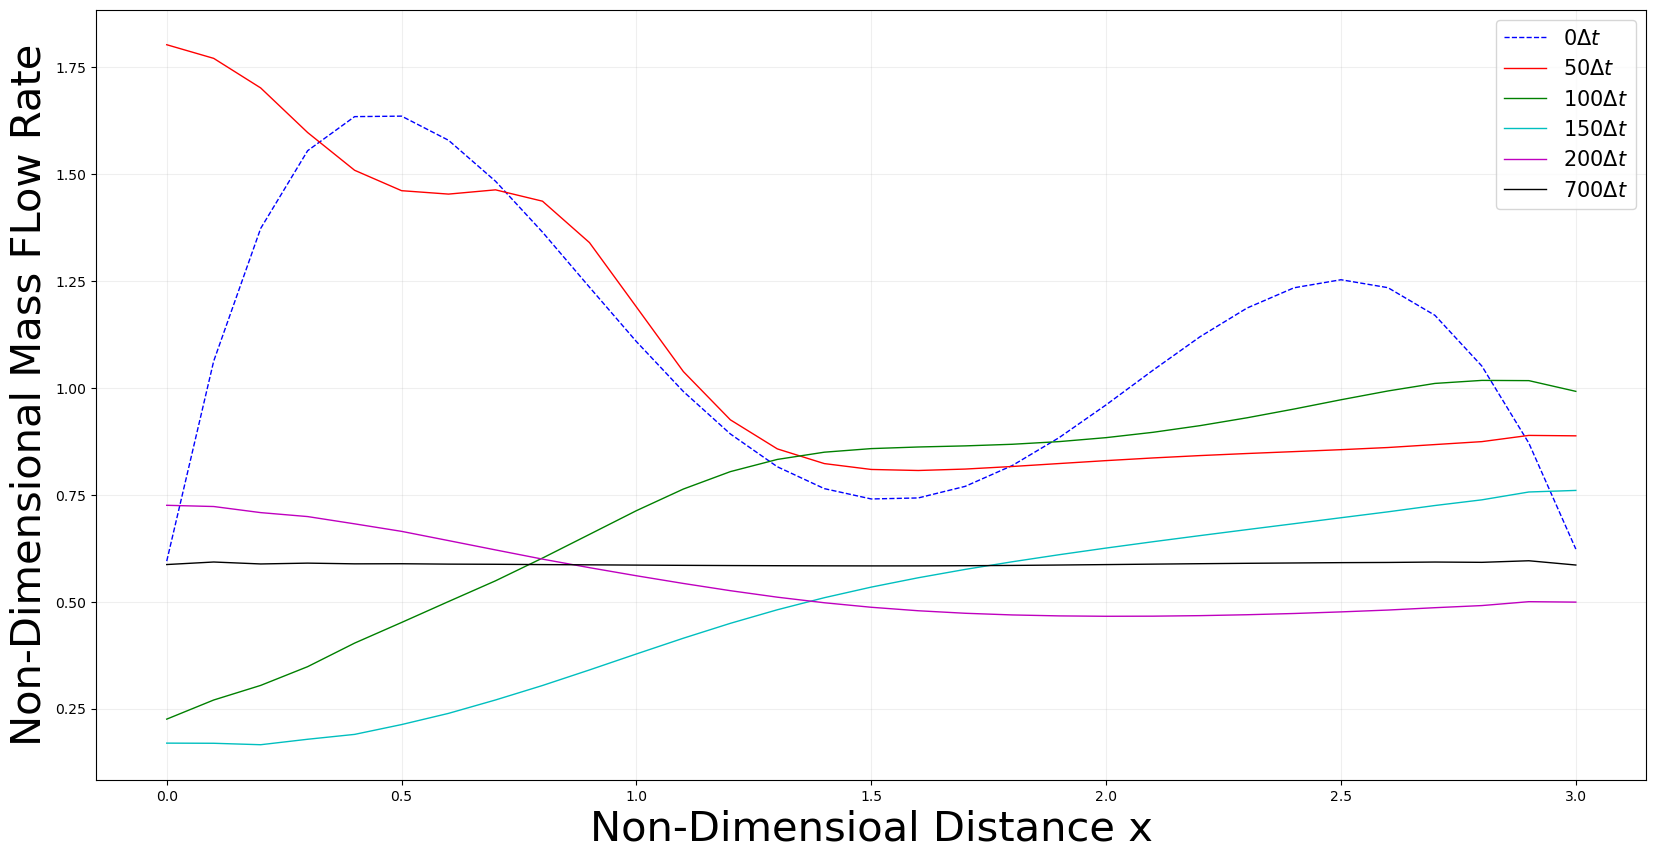

In [27]:
fig = plt.figure(figsize=(20,10), dpi = 100)
ax = fig.add_subplot(111)
ax.plot(x[:], mass_flow_rate_initial[:], '--', color = 'b', label = r"$0\Delta t$",linewidth = 1)
ax.plot(x[:], mass_flow_50[:], color = 'r', label = r"$50\Delta t$",linewidth = 1)
ax.plot(x[:], mass_flow_100[:], color = 'g',label = r"$100\Delta t$",linewidth = 1)
ax.plot(x[:], mass_flow_150[:], color = 'c',label = r"$150\Delta t$",linewidth = 1)
ax.plot(x[:], mass_flow_200[:], color = 'm',label = r"$200\Delta t$",linewidth = 1)
ax.plot(x[:], mass_flow_700[:], color = 'k',label = r"$700\Delta t$",linewidth = 1)

ax.set_xlabel("Non-Dimensioal Distance x")
ax.set_ylabel("Non-Dimensional Mass FLow Rate")
ax.grid(which='major', alpha = 0.2)
ax.grid(which='minor', alpha = 0.5)
plt.rc('axes', labelsize = 20)
ax.legend(prop={'size': 15})

In [28]:
rho_analytical = np.array([0.995,0.994,0.992,0.990,0.987,0.983,0.978,0.970,0.958,0.942, 0.920,0.888,0.844,0.787,0.716,0.634,0.547,0.461,0.382,0.315,0.258,0.213,0.176,0.147,0.124,0.105,0.090,0.078,0.068,0.059,0.052])

In [29]:
rho_analytical.size

31

In [30]:
mach_analytical = np.array([0.098,0.110,0.124,0.140,0.160,0.185,0.214,0.249,0.293,0.347,0.413,0.494,0.592,0.709,0.845,1.000,1.169,1.348,1.531,1.715, 1.896,2.071,2.240,2.402,2.557,2.706,2.848,2.983,3.114,3.239,3.359])

In [31]:
mach_analytical.size

31

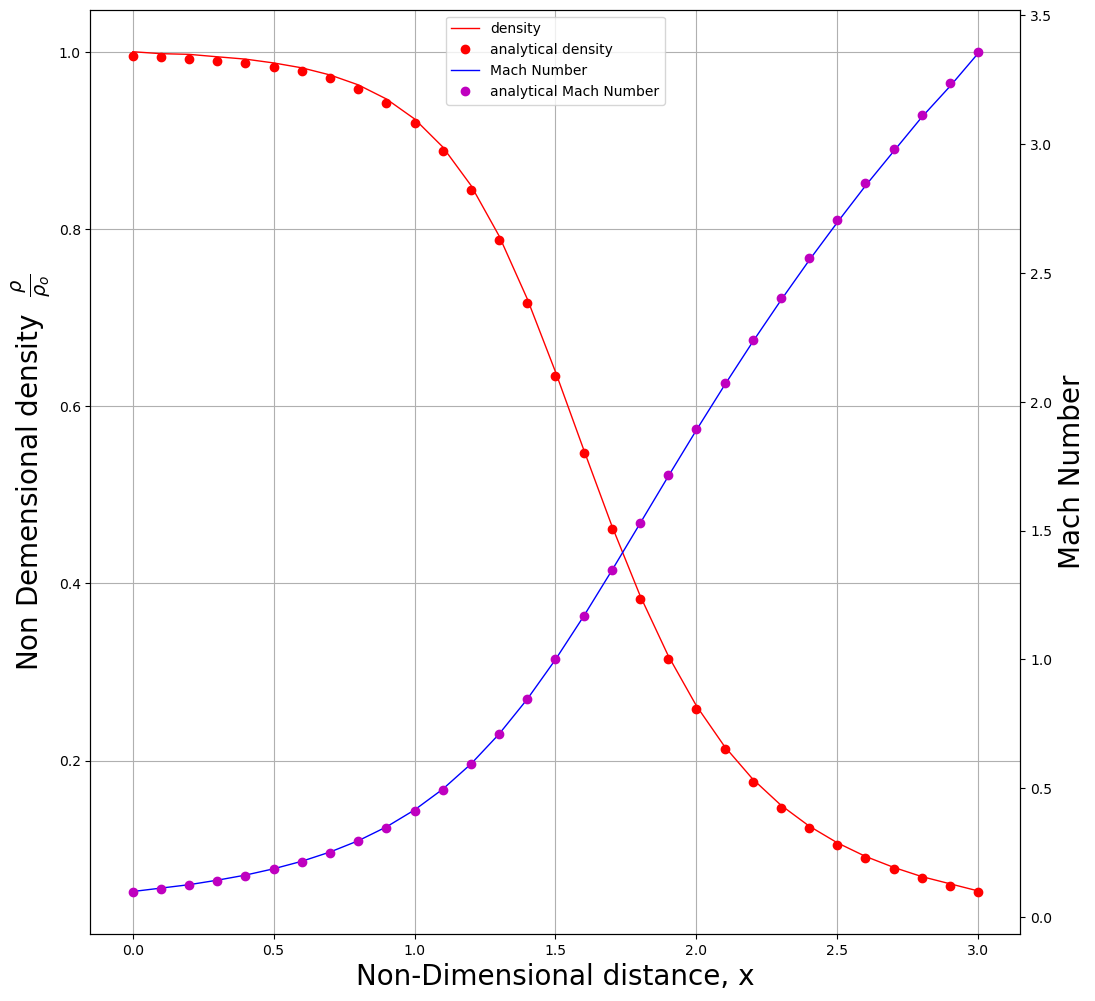

In [32]:
fig = plt.figure(figsize=(12,12), dpi = 100)
ax = fig.add_subplot(111)
ax.plot(x[:], rho[:], label = 'density', linewidth = 1, color = 'red')
ax2 = ax.twinx()
ax2.plot(x[:], mach_number[:], label = 'Mach Number',linewidth = 1,color = 'blue')
ax.plot(x[:], rho_analytical[:], 'o', color = 'r',label = 'analytical density')
ax2.plot(x[:], mach_analytical[:], 'o', color= 'm', label = 'analytical Mach Number')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=9,prop={'size': 10})
ax.set_xlabel("Non-Dimensional distance, x")
ax.set_ylabel(r"Non Demensional density  $\frac{\rho}{\rho_o}$")
ax2.set_ylabel("Mach Number")
ax.grid()
plt.show()

In [33]:
mass_flow

array([0.58775196, 0.59366145, 0.58907473, 0.59098615, 0.58924812,
       0.58940831, 0.58846109, 0.58801684, 0.58724032, 0.58659252,
       0.5858837 , 0.58526534, 0.58472032, 0.58428871, 0.5839613 ,
       0.58376859, 0.58379328, 0.58412313, 0.5847734 , 0.58566774,
       0.58668816, 0.58773277, 0.58871668, 0.58963059, 0.59039528,
       0.59115712, 0.59158921, 0.59251624, 0.59182738, 0.59551323,
       0.5855348 ])

In [34]:
import pandas as pd

df_mass_flow_nozze_1 = pd.DataFrame(mass_flow)

In [35]:
df_mass_flow_nozze_1

,0
0,0.587752
1,0.593661
2,0.589075
3,0.590986
4,0.589248
5,0.589408
6,0.588461
7,0.588017
8,0.587240
9,0.586593


In [36]:
df_mass_flow_nozze_1.to_csv("non_coservative_nozzle.csv")